## Functions

In [1]:
def plot_prob(y_pred):
    """Plots the highest probability out of the output vector of a model for each class."""
    prob_value = list(map(max, y_pred))
    y_pred_class = y_pred.argmax(axis=1)

    predict_df = pd.DataFrame({"pred_class": y_pred_class, "prob_value": prob_value})
    classes = np.sort(predict_df["pred_class"].unique())
    
    num_classes = len(classes)
    # nrow = int(np.ceil(num_classes / 3))
    # ncol = int(np.ceil(num_classes / nrow))
    fig, axes = plt.subplots(nrows=1, ncols=num_classes, figsize=(4 * num_classes, 3.5 * 1))

    for i, clas in enumerate(classes):
        ax = axes[i]  # Accessing axes using 2D indexing
        #sns.kdeplot(predict_df.loc[predict_df["pred_class"] == clas, "prob_value"], ax=ax)
        ax.hist(predict_df.loc[predict_df["pred_class"] == clas, "prob_value"], bins=10, orientation='horizontal')
        ax.set_title(f"Probability distribution for predicted class {clas}")
        ax.set_ylabel("Density")
        ax.set_xlabel("Values")

    plt.tight_layout()
    plt.show()
    

In [2]:
def plot_prob_density(y_pred):
    """Plots probablity density plot out of the output vector of a model for each class."""
    prob_value = list(map(max, y_pred))
    y_pred_class = y_pred.argmax(axis=1)

    predict_df = pd.DataFrame({"pred_class": y_pred_class, "prob_value": prob_value})
    classes = np.sort(predict_df["pred_class"].unique())
    
    num_classes = len(classes)
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for clas in classes:
        sns.kdeplot(predict_df.loc[predict_df["pred_class"] == clas, "prob_value"], label=f"Class {clas}", ax=ax, bw_adjust=0.5)
    
    ax.set_title("Probability Density for Predicted Classes")
    ax.set_ylabel("Density")
    ax.set_xlabel("Values")
    ax.set_xlim(0, 1)
    ax.legend()
    
    plt.tight_layout()
    plt.show()



In [3]:
# function for evaluatig model 

def evaluate_model(model, history, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_class = y_pred.argmax(axis=1)
    y_test_class = y_test.argmax(axis=1)
    print(y_pred_class)
    print(y_test_class)
    # Assuming plot_prob is defined elsewhere
    #plot_prob(y_pred)
    plot_prob_density(y_pred)
    sample_weight = (y_pred_class != y_test_class)
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_pred_class, y_test_class, #sample_weight=sample_weight,
                                             normalize="true", values_format=".0%")

    # Plot training and validation loss
    fig, ax = plt.subplots()
    ax.plot(history.history["loss"], 'r', marker='.', label="Train Loss")
    ax.plot(history.history["val_loss"], 'b', marker='.', label="Validation loss")
    ax.legend()
    ax.set_title("DNN_Gut_loss")

    # Plot training and validation accuracy
    fig, ax = plt.subplots()
    ax.plot(history.history["accuracy"], 'r', marker='.', label="Train accuracy")
    ax.plot(history.history["val_accuracy"], 'b', marker='.', label="Validation accuracy")
    ax.legend()
    ax.set_title("DNN_Gut_acc")


In [5]:
#creting decoder for 5 classes (original experimental setups)
# codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}

def pond_decoder(x,codes):
    """Function to decode pond names into classes 
    to be applied to dataset
    takes:
    x - value
    codes - dictionary of what pond goes to which class
    """
    
    x=x.replace('S','')
    num = int(x.split("_")[1])
    
    
    for key, value_list in codes.items():
        if num in value_list:
            return key
    
    return None   

## libraries import and data loading

if you want you can run this notebook in google colaboratory platfotm using [this link](https://colab.research.google.com/github/paq88/Neural_network_classifier/blob/main/Fish_model_NN_gut.ipynb)


In [6]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
# for tensorboard logs
import datetime
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [7]:
# load data from github 

df = pd.read_csv('https://raw.githubusercontent.com/paq88/Neural_network_classifier/main/data/gut_full_feature_table.csv')
print(df.shape)
print(df.dtypes)
df.head()

(124, 127)
pond                                                                                           object
d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae             float64
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae       float64
d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae                    float64
d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae                    float64
                                                                                               ...   
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae           float64
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae      float64
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae           float64
d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales

,pond,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
0,Gut_S10,2319.0,2187.0,1743.0,500.0,521.0,286.0,366.0,612.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Gut_S10,3391.0,2071.0,355.0,1054.0,1024.0,1952.0,66.0,217.0,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Gut_S10,1338.0,7053.0,669.0,279.0,329.0,63.0,52.0,1338.0,139.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gut_S10,1582.0,15595.0,124.0,503.0,309.0,5.0,3418.0,326.0,76.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gut_S10,1463.0,3891.0,541.0,7.0,13.0,11.0,61.0,398.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df = df.fillna(0)

In [9]:
df.describe()

,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,...,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,831.653226,8693.169355,171.370968,71.137097,105.548387,196.209677,677.419355,375.854839,53.169355,25.241935,...,0.096774,0.298387,0.080645,2.153226,0.217742,1.604839,0.153226,0.096774,0.266129,0.185484
std,1120.105607,5604.123141,224.484829,146.755443,192.490201,637.902078,2845.964849,456.780652,98.483354,67.552253,...,1.077632,2.270274,0.898027,20.938565,2.093585,13.805159,1.706250,1.077632,2.537872,2.065461
min,0.000000,167.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,106.750000,3913.500000,37.750000,0.000000,0.000000,6.750000,0.000000,55.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,469.500000,7454.500000,105.500000,2.000000,13.500000,27.500000,0.000000,211.000000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1037.750000,12774.000000,241.000000,91.500000,131.000000,118.250000,48.750000,467.250000,62.250000,15.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6597.000000,26160.000000,1743.000000,1054.000000,1024.000000,5020.000000,23193.000000,2505.000000,581.000000,539.000000,...,12.000000,23.000000,10.000000,232.000000,23.000000,144.000000,19.000000,12.000000,28.000000,23.000000


In [10]:
keras.utils.set_random_seed(333)

# Train - Test split normalisation and  PCA transformation


## Target variable decoding 
We will split into 2 classes as this proved to be best approach earlier.

In [14]:
target = ['pond']
predictors = list(set(list(df.columns)) - set(target))
df.shape


(124, 127)

In [11]:
#performing change of target variable collumn 
#codes = {0 : [8,14,18,24,29,12,16,19,23,26,9,13,17,20,27], 1 : [10,21,28,30,32,11,15,22,25,31]}
codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}

df['pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))


In [12]:
df.head(2)

,pond,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
0,2,2319.0,2187.0,1743.0,500.0,521.0,286.0,366.0,612.0,160.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,3391.0,2071.0,355.0,1054.0,1024.0,1952.0,66.0,217.0,95.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train - Test Split

In [16]:
X=df[predictors].values
y=df[target].values
yc = keras.utils.to_categorical(y, 5)
X_train, X_test, y_train, y_test = train_test_split(X,yc,test_size=0.2,random_state=111,stratify = yc,shuffle = True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


(99, 126) (25, 126) (99, 5) (25, 5)


## Normalisation
here we will use same min/max normalisation as before, later we will test standard scaler.

In [19]:
df.describe()

,pond,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,...,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,2.016129,0.126065,0.332308,0.098320,0.067493,0.103075,0.039086,0.029208,0.150042,0.091514,...,0.008065,0.012973,0.008065,0.009281,0.009467,0.011145,0.008065,0.008065,0.009505,0.008065
std,1.414121,0.169790,0.214225,0.128792,0.139237,0.187979,0.127072,0.122708,0.182348,0.169507,...,0.089803,0.098708,0.089803,0.090252,0.091025,0.095869,0.089803,0.089803,0.090638,0.089803
min,0.000000,0.000000,0.006384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.016182,0.149599,0.021658,0.000000,0.000000,0.001345,0.000000,0.022156,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.071169,0.284958,0.060528,0.001898,0.013184,0.005478,0.000000,0.084232,0.006885,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.157306,0.488303,0.138267,0.086812,0.127930,0.023556,0.002102,0.186527,0.107143,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
df[predictors]=df[predictors]/df[predictors].max()


## PCA transformation
In this section we will dive into PCA transformation to see if reduction of dimentionality using PCA will help in our research.

In [20]:
from sklearn.decomposition import PCA

In [21]:
pca = PCA(0.9, svd_solver = 'full') # we want to have 90 percent of variance captured

In [22]:
pca.fit(X_train)

PCA(n_components=0.9, svd_solver='full')

In [23]:
print(f"number of compoments: {pca.n_components_}")

number of compoments: 2


In [24]:
print(f"variance explained by each component: {pca.explained_variance_ratio_}")

variance explained by each component: [0.70865877 0.2028464 ]


In [25]:
?PCA

Init signature:
PCA(
    n_components=None,
    *,
    copy=True,
    whiten=False,
    svd_solver='auto',
    tol=0.0,
    iterated_power='auto',
    n_oversamples=10,
    power_iteration_normalizer='auto',
    random_state=None,
)
Docstring:     
Principal component analysis (PCA).

Linear dimensionality reduction using Singular Value Decomposition of the
data to project it to a lower dimensional space. The input data is centered
but not scaled for each feature before applying the SVD.

It uses the LAPACK implementation of the full SVD or a randomized truncated
SVD by the method of Halko et al. 2009, depending on the shape of the input
data and the number of components to extract.

It can also use the scipy.sparse.linalg ARPACK implementation of the
truncated SVD.

Notice that this class does not support sparse input. See
:class:`TruncatedSVD` for an alternative with sparse data.

Read more in the :ref:`User Guide <PCA>`.

Parameters
----------
n_components : int, float or 'mle', def

In [26]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

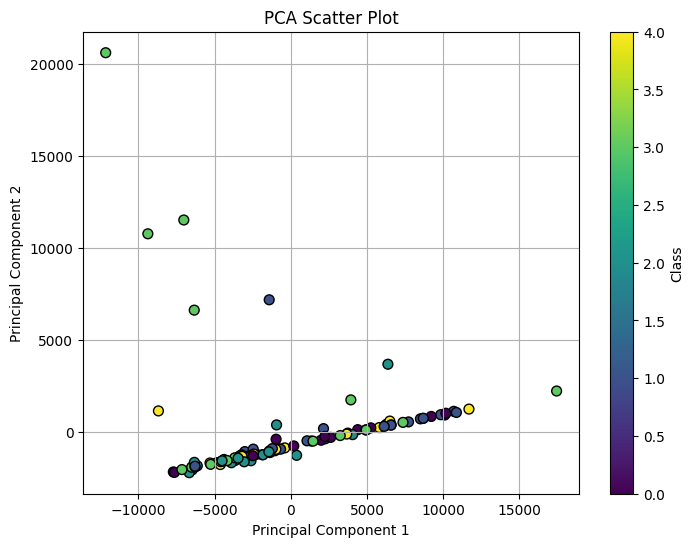

In [27]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c = y_train.argmax(axis=1), cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.colorbar(label='Class')
plt.grid(True)
plt.show()

In [28]:
X_train_pca[:5]

array([[ 4394.46836097,   130.50770304],
       [ 3744.39388713,   -57.26777456],
       [-3649.00518446, -1542.36595333],
       [-5298.73568937, -1680.45343411],
       [-4382.99865313, -1489.09008442]])

So it seems that we can captrue 90 percent of variance with only 2 principal components this is weird as we reduced dimentionality by quite a lot from 125 features to only 2 lets try to capture more of variance 

In [29]:
pca_99 = PCA(0.99, svd_solver = 'full') # we want to have 90 percent of variance captured
pca_99.fit(X_train)
pca_99.n_components_

6

In [30]:
print(f"variance explained by each component: {pca_99.explained_variance_ratio_}")

variance explained by each component: [0.70865877 0.2028464  0.03008756 0.02543755 0.01520843 0.00793731]


In [31]:
X_train_pca_99 = pca_99.transform(X_train)
X_test_pca_99 = pca_99.transform(X_test)


We need only 6 compoments to captpure almost all of variance.

## Crossvalidation

In [27]:
target = ['pond']
predictors = list(set(list(df.columns)) - set(target))
df.shape

(124, 127)

In [28]:
X=df[predictors].values
y=df[target].values
X_cross, X_test, y_cross, y_test = train_test_split(X,y,test_size=0.2,random_state=111,stratify = y,shuffle = True)
print(X_cross.shape,X_test.shape,y_train.shape,y_test.shape)


(99, 126) (25, 126) (99, 2) (25, 1)


Now we have training set with 99 samples as well as test set with 25 samples (one from each pond), we will use that test set near the end for when we have final model. our trainig set we will divide into 4 subsets of which one will be used as validation and rest as a training. 

In [29]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4)
skf
skf.get_n_splits(X_cross, y_cross)

print(skf)

for i, (train_index, test_index) in enumerate(skf.split(X_cross, y_cross)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

StratifiedKFold(n_splits=4, random_state=None, shuffle=False)
Fold 0:
  Train: index=[25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98]
  Test:  index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Fold 1:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 49 50 51 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98]
  Test:  index=[25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 52]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 52 72 73 74 76 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98]
  

## model building and compiling
So let us now fit model to our PCA transformed data we will do that for 90% and 99% of variance so for 2 and 6 principal components we wil use same architecture as before 

In [32]:
model = keras.Sequential()



model.add(keras.layers.Dense(4,input_shape=(X_train_pca.shape[1],),activation='relu'))


#model.add(keras.layers.Dropout(rate=0.25))
#model.add(keras.layers.Dense(64, activation ='relu'))
#model.add(keras.layers.Dropout(rate=0.25))
#model.add(keras.layers.Dense(8, activation ='relu'))

model.add(keras.layers.Dense(5, activation ='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 12        
                                                                 
 dense_1 (Dense)             (None, 5)                 25        
                                                                 
Total params: 37 (148.00 Byte)
Trainable params: 37 (148.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = "accuracy"
# worth trying same loss as metrics
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model.compile(optimizer = optimizer, loss = loss, metrics=metrics)

## model fiting 


In [37]:

history=model.fit(X_train_pca, y_train, epochs = 300, verbose = 1, shuffle = True, validation_data=(X_test_pca, y_test))


Epoch 1/300
4/4 [==============================] - 1s 67ms/step - loss: 1922.8259 - accuracy: 0.1818 - val_loss: 2416.8364 - val_accuracy: 0.2000
Epoch 2/300
4/4 [==============================] - 0s 14ms/step - loss: 1918.4279 - accuracy: 0.1818 - val_loss: 2411.9277 - val_accuracy: 0.2000
Epoch 3/300
4/4 [==============================] - 0s 14ms/step - loss: 1913.9866 - accuracy: 0.1818 - val_loss: 2407.0710 - val_accuracy: 0.2000
Epoch 4/300
4/4 [==============================] - 0s 13ms/step - loss: 1909.8105 - accuracy: 0.1818 - val_loss: 2402.3032 - val_accuracy: 0.2000
Epoch 5/300
4/4 [==============================] - 0s 13ms/step - loss: 1905.3213 - accuracy: 0.1717 - val_loss: 2397.5881 - val_accuracy: 0.2000
Epoch 6/300
4/4 [==============================] - 0s 12ms/step - loss: 1901.1459 - accuracy: 0.1717 - val_loss: 2392.8379 - val_accuracy: 0.2000
Epoch 7/300
4/4 [==============================] - 0s 12ms/step - loss: 1897.0096 - accuracy: 0.1717 - val_loss: 2388.1101 -

1/1 [==============================] - 0s 94ms/step
[4 4 4 4 4 4 4 0 4 4 4 4 4 4 3 4 4 4 4 4 4 3 4 4 4]
[4 4 1 0 3 1 2 3 3 2 1 1 2 0 4 2 3 0 4 2 0 4 3 1 0]


C:\Users\marek\AppData\Local\Temp\ipykernel_3632\3158418901.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(predict_df.loc[predict_df["pred_class"] == clas, "prob_value"], label=f"Class {clas}", ax=ax, bw_adjust=0.5)


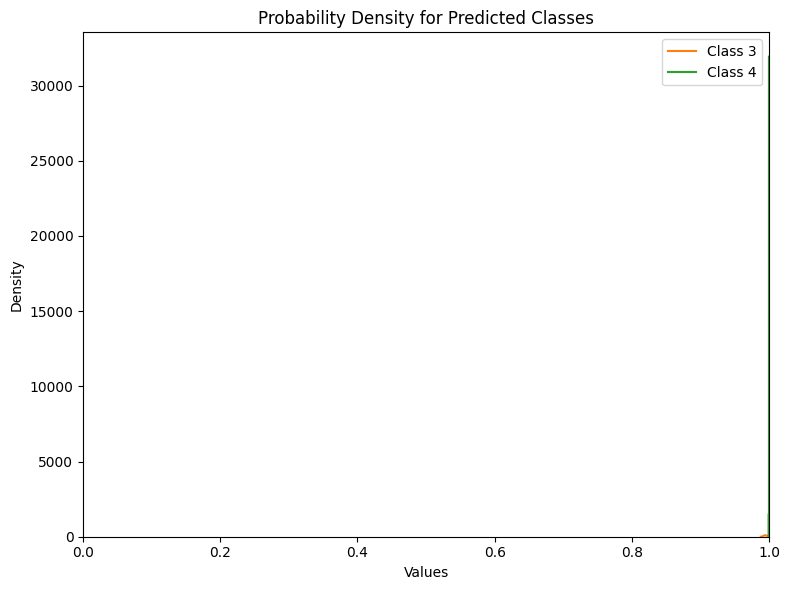

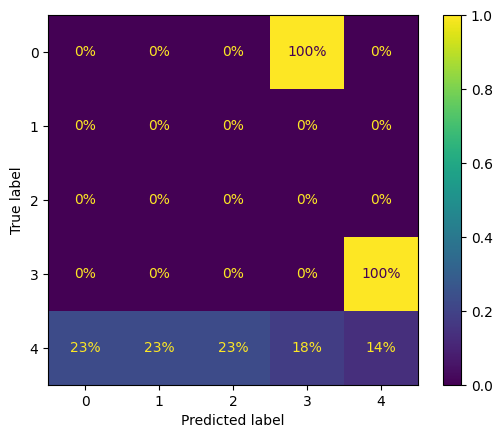

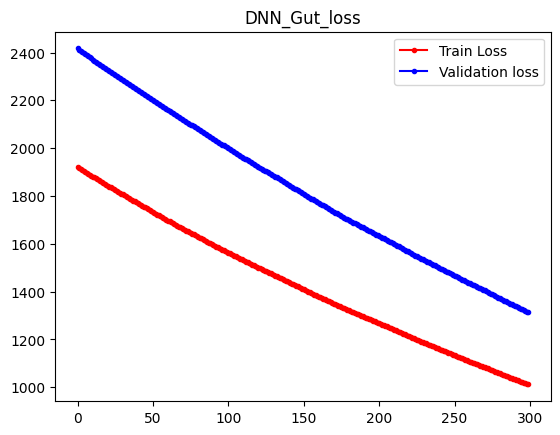

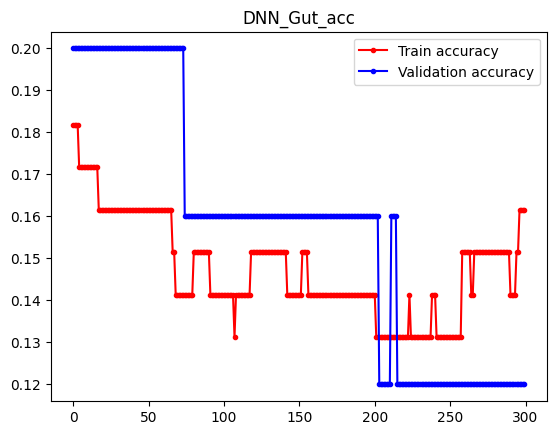

In [38]:
evaluate_model(history = history, model = model, X_test = X_test_pca, y_test = y_test)

What we can note here is that the model is performing very poor, it might be caused by low number of features only 2 so lets try with 6 features/components

In [43]:
model2 = keras.Sequential()


model2.add(keras.layers.Dense(128,input_shape=(X_train_pca_99.shape[1],),activation='relu'))


model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(8, activation ='relu'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               896       
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 5)                 45        
                                                                 
Total params: 9717 (37.96 KB)
Trainable params: 9717 (

In [44]:
loss = "categorical_crossentropy"
#loss = "sparse_categorical_crossentropy"
metrics = "accuracy"
# worth trying same loss as metrics
optimizer = keras.optimizers.Adam(learning_rate = 0.0005)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

In [45]:


history2_2=model2.fit(X_train_pca_99, y_train, epochs = 300, verbose = 1, shuffle = True, validation_data=(X_test_pca_99, y_test))


Epoch 1/300
4/4 [==============================] - 1s 94ms/step - loss: 350.8785 - accuracy: 0.2525 - val_loss: 126.8785 - val_accuracy: 0.2400
Epoch 2/300
4/4 [==============================] - 0s 15ms/step - loss: 317.0049 - accuracy: 0.2323 - val_loss: 112.7276 - val_accuracy: 0.2400
Epoch 3/300
4/4 [==============================] - 0s 17ms/step - loss: 234.0524 - accuracy: 0.2626 - val_loss: 66.8438 - val_accuracy: 0.2800
Epoch 4/300
4/4 [==============================] - 0s 15ms/step - loss: 251.7167 - accuracy: 0.2121 - val_loss: 48.9982 - val_accuracy: 0.2400
Epoch 5/300
4/4 [==============================] - 0s 15ms/step - loss: 183.7881 - accuracy: 0.1919 - val_loss: 36.5158 - val_accuracy: 0.2800
Epoch 6/300
4/4 [==============================] - 0s 14ms/step - loss: 183.9536 - accuracy: 0.2323 - val_loss: 35.0561 - val_accuracy: 0.2400
Epoch 7/300
4/4 [==============================] - 0s 12ms/step - loss: 140.7749 - accuracy: 0.1818 - val_loss: 37.7233 - val_accuracy: 0.28

1/1 [==============================] - 0s 118ms/step


C:\Users\marek\AppData\Local\Temp\ipykernel_3632\3158418901.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(predict_df.loc[predict_df["pred_class"] == clas, "prob_value"], label=f"Class {clas}", ax=ax, bw_adjust=0.5)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[4 4 1 0 3 1 2 3 3 2 1 1 2 0 4 2 3 0 4 2 0 4 3 1 0]


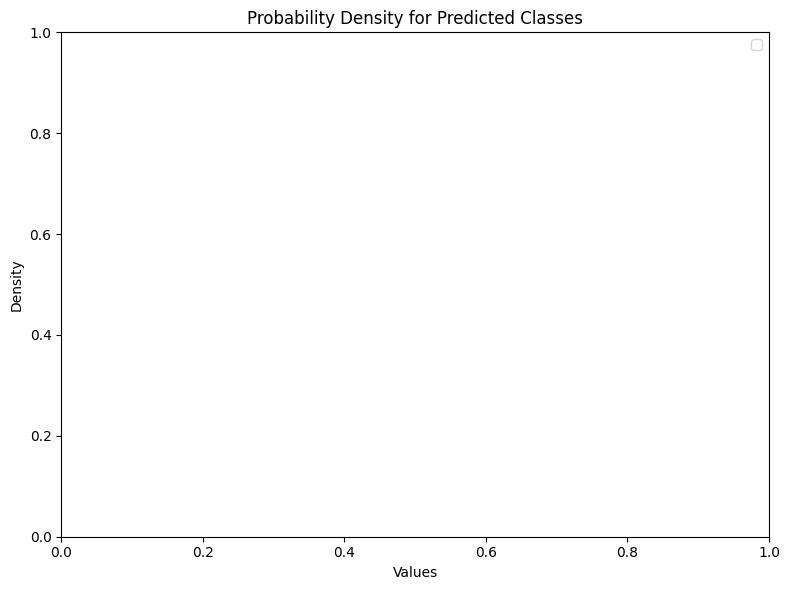

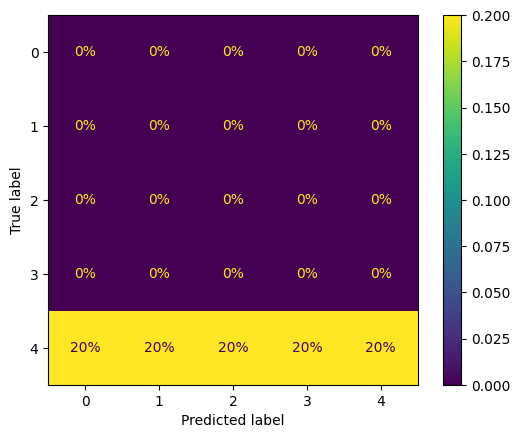

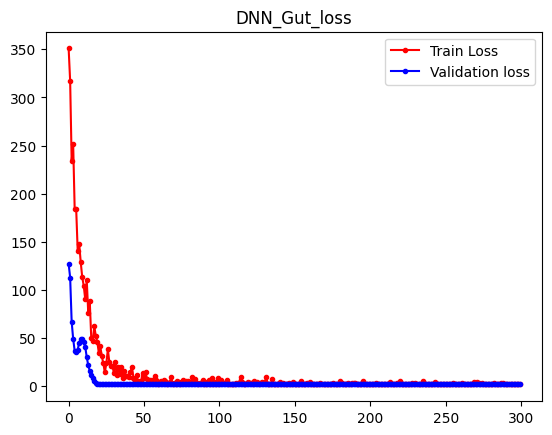

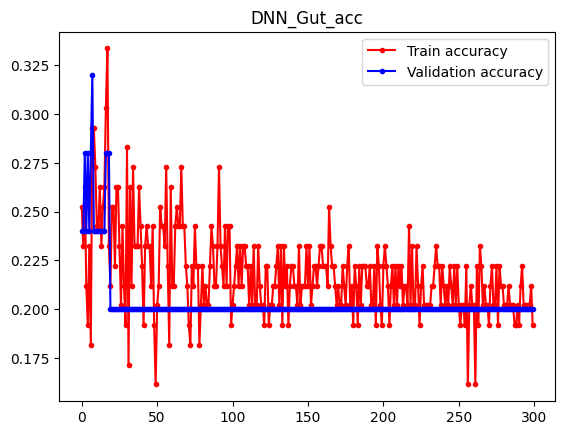

In [46]:
evaluate_model(model2, history2_2, X_test_pca_99, y_test)

We can note here that alothough results are better than for 2 components model is still performing very badly, it seems that there is close to no learning happepning although loss function is dropping there is very little improvement in accuracy even after making model much lighter by changing its architecture